# Python libraries for evolutionary computation

* PaGMO/PyGMO
* Inspyred
* PyEvolve
* **Distributed Evolutionary Algorithms in Python (DEAP)**


<table>
<tr>
<td width='47%'>
<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' title="DEAP logo" width='92%' align='center'/>
</td>
<td>
<ul>
<li> Open source Python library with,
<li> genetic algorithm using any representation;
<li> evolutionary strategies (including CMA-ES);
<li> multi-objective optimization from the start;
<li> co-evolution (cooperative and competitive) of multiple populations;
<li> parallelization of the evaluations (and more) using SCOOP;
<li> statistics keeping, and;
<li> benchmarks module containing some common test functions.
<li> [https://github.com/DEAP/deap](https://github.com/DEAP/deap)
</ul>
</td>
</tr>
</table>

<hr/>
<div class="container-fluid">
    <div class="col-md-12" align='center'>
        <img align='center'alt="Creative Commons License" style="border-width:0" src="https://www.researchgate.net/profile/David_Wong9/publication/50264725/figure/fig9/AS:214304679829519@1428105625507/Flowchart-of-the-Genetic-algorithm-workflow-The-first-population-was-generated-randomly.png"/>
    </div>
    <p>An example schematic of how a Genetic Algorithm works.</p>
</div>

# Symbolic Regression Problem: Introduction to GP using DEAP


Symbolic regression is one of the best known problems in GP. It is commonly used as a tuning problem for new algorithms, but is also widely used with real-life distributions, where other regression methods may not work. It is conceptually a simple problem, and therefore makes a good introductory example for the GP framework in DEAP.

All symbolic regression problems use an arbitrary data distribution, and try to fit the most accurately the data with a symbolic formula. Usually, a measure like the RMSE (Root Mean Square Error) is used to measure an individual’s fitness.

In this example, we use a classical distribution, the quartic polynomial (x^4 + x^3 + x^2 + x), a one-dimension distribution. 20 equidistant points are generated in the range [-1, 1], and are used to evaluate the fitness.

<hr/>
<p>Symbolic Regression with Genetic Programming</p>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-12" align='center'>
              <img align='center'alt=“Genetic Programming“ style="border-width:0" src="http://inspirehep.net/record/1421690/files/trees.png"/>
          </div>
      </div>
  </div>
</div>


# Creating the primitives set

One of the most crucial aspect of a GP program is the choice of the primitives set. They should make good building blocks for the individuals so the evolution can succeed. In this problem, we use a classical set of primitives, which are basic arithmetic functions:

In [2]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
!pip install deap

Selecting previously unselected package libgtk2.0-common.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.32-1ubuntu1_all.deb ...
Unpacking libgtk2.0-common (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libxdot4.
Preparing to unpack .../4-libxdot4_2.40.1-2_amd64.deb ...
Unpacking libxdot4 (2.40.1-2) ...
Selecting previously unselected package libgvc6-plugins-gtk.
Prep

In [0]:
# first, our imports
import operator
import math
import random
import numpy as np
from deap import algorithms, base, creator, tools, gp

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

The redefinition of the division is made to protect it against a zero division error (which would crash the program). The other functions are simply a mapping from the Python **operator** module. The number following the function is the arity of the primitive, that is the number of entries it takes.

On the last line, we declare an **Ephemeral** constant. This is a special terminal type, which does not have a fixed value. When the program appends an ephemeral constant terminal to a tree, the function it contains is executed, and its result is inserted as a constant terminal. In this case, those constant terminals can take the values -1, 0 or 1.

The second argument of **PrimitiveSet** is the number of inputs. Here, as we have only a one dimension regression problem, there is only one input, but it could have as many as you want. By default, those inputs are named **“ARGx”**, where **“x”** is a number, but you can easily rename them :

In [0]:
pset.renameArguments(ARG0='x')

# Creator

As any evolutionary program, symbolic regression needs (at least) two object types : an individual containing the genotype and a fitness. We can easily create them with the creator:

In [0]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

The first line creates the fitness object (this is a minimization problem, so the weight is negative). The weights argument must be an iterable of weights, even if there is only one fitness measure. The second line create the individual object itself. Very straightforward, we can see that it will be based upon a tree, to which we add a fitness. If, for any reason, the user would want to add any other attribute (for instance, a file in which the individual will be saved), it would be as easy as adding this attribute of any type to this line. After this declaration, any individual produced will contain those wanted attributes.

# Toolbox

Now, we want to register some parameters specific to the evolution process. In DEAP, this is done through the toolbox:

In [0]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Even if the fitness only contains one measure, keep in mind that DEAP 
# stores it as an iterable. Knowing that, you can understand why the evaluation 
# function must return a tuple value (even if it is a 1-tuple):
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

First, a toolbox instance is created (in some problem types like coevolution, you may consider creating more than one toolbox). Then, we can register any parameters. The first lines register how to create an individual (by calling **gp.genRamped** with the previously defined primitive set), and how to create the population (by repeating the individual initialization).

We may now introduce the evaluation function, which will receive an individual as input, and return the corresponding fitness. This function uses the compile function previously defined to transform the individual into its executable form – that is, a program. After that, the evaluation is only simple maths, where the difference between the values produced by the evaluated individual and the real values are squared and summed to compute the RMSE, which is returned as the fitness of the individual.

Afterwards, we register the evaluation function. We also choose the selection method (a tournament of size 3), the mate method (one point crossover with uniform probability over all the nodes), the mutation method (an uniform probability mutation which may append a new full sub-tree to a node).

Then, we decorate the mate and mutate method to limit the height of generated individuals. This is done to avoid an important draw back of genetic programming : bloat. Koza in his book on genetic programming suggest to use a max depth of 17.

At this point, any structure with an access to the toolbox instance will also have access to all of those registered parameters. Of course, the user could register other parameters basing on his needs.

# Statistics

Although optional, statistics are often useful in evolutionary programming. DEAP offers a simple class which can handle most of the “boring work”. In this case, we want to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size. For that we’ll use a **MultiStatistics** object.

In [0]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Launching the evolution

At this point, DEAP has all the information needed to begin the evolutionary process, but nothing has been initialized. We can start the evolution by creating the population and then calling a complete algorithm. In this case, we’ll use **eaSimple()**.

The hall of fame is a specific structure which contains the n best individuals (here, the best one only).

In [8]:
verbose = False
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)  # we only want the best individual
pop, log = algorithms.eaSimple(pop, 
                               toolbox, 
                               0.5, 
                               0.1, 
                               40, 
                               stats=mstats,
                               halloffame=hof, 
                               verbose=verbose)

# see the best solution
print(hof[0])

mul(add(x, mul(x, x)), add(mul(x, x), 1))


# Visualizing the result

Note, this requires `graphviz` to be installed on the system!

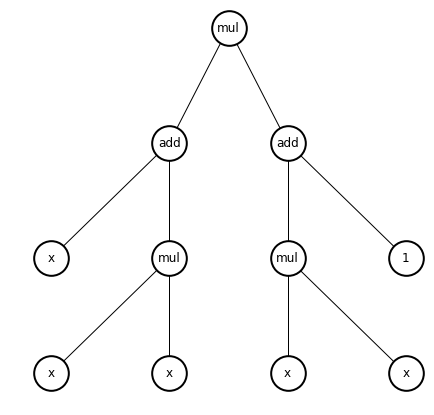

In [9]:
import networkx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

%matplotlib inline

nodes, edges, labels = gp.graph(hof[0])
graph = networkx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

plt.figure(figsize=(7, 7))
diagram = networkx.draw_networkx_nodes(graph, pos, node_size=1200, node_color="w", linewidths=2.0)

diagram.set_edgecolor('k')
networkx.draw_networkx_edges(graph, pos)
networkx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()


# Multiprocessing

Increase the performance of your computations by prepending the following code before evaluation. Note that processes are roughly analogous to virtual CPUs. In other words, if you have a quad-core computer using 4 processes is good. Using more may slow down your calculation overall.

```
import multiprocessing

# define the number of processes you want to use here
pool = multiprocessing.Pool(processes=4)
toolbox.register("map", pool.map)
```

# Activity 1: Find the solution which fits the data from "*`function_data1.txt`*". Define / use any operators you may need. Evaluate / plot the best fit solution against the input data.
Hint: instead of comparing each chromosome against an exact function, compare the chromosomes against the data contained in the file "*`function_data1.txt`*" when fitting.

# Activity 2: Find the solution which fits the data from "*`function_data2.txt`*" against a chromosome which takes 2 arguments when fitting. Define / use any operators you may need. Evaluate / plot the best fit solution against the input data.
Hint: Instead of using a list of 1D points, you may need to create a list of 2D points which will be evaluated over a known range.

In [11]:
!wget https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%205%20-%20Goal%204%20-%20Scientific%20Insights%20from%20Learned%20Models/Ex%202%20-%20Math%20Models%202%20Symbolic%20regression/function_data1.txt
!wget https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%205%20-%20Goal%204%20-%20Scientific%20Insights%20from%20Learned%20Models/Ex%202%20-%20Math%20Models%202%20Symbolic%20regression/function_data2.txt

--2019-08-13 14:58:30--  https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%205%20-%20Goal%204%20-%20Scientific%20Insights%20from%20Learned%20Models/Ex%202%20-%20Math%20Models%202%20Symbolic%20regression/function_data1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510 [text/plain]
Saving to: ‘function_data1.txt’

function_data1.txt  100%[===================>]     510  --.-KB/s    in 0s      

2019-08-13 14:58:30 (63.6 MB/s) - ‘function_data1.txt’ saved [510/510]

--2019-08-13 14:58:31--  https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%205%20-%20Goal%204%20-%20Scientific%20Insights%20from%20Learned%20Models/Ex%202%20-%20Math%20Models%202%20Symbolic%20regression/function_data2.txt
Resolving raw.gith

In [12]:
text_file = open("./function_data1.txt", "r")
lines = text_file.readlines()
lines=[float(x) for x in lines]
text_file.close()
print(lines[1])
type(lines[0])

-810.001110688


float

# Extra: Use the `sympy` package to simplify and beautify the best fit solution.

# Reference
John R. Koza, *“Genetic Programming: On the Programming of Computers by Means of Natural Selection”, MIT Press, 1992, pages 162-169.*

# SINDy

There exists a python library called "[pySINDy](https://github.com/luckystarufo/pySINDy)" but I noticed some misconceptions and have not tested. SINDy is easy to implement so what follows is our in-lab implementation. 

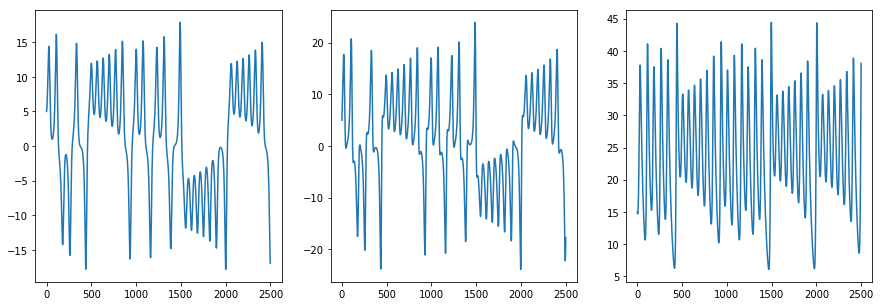

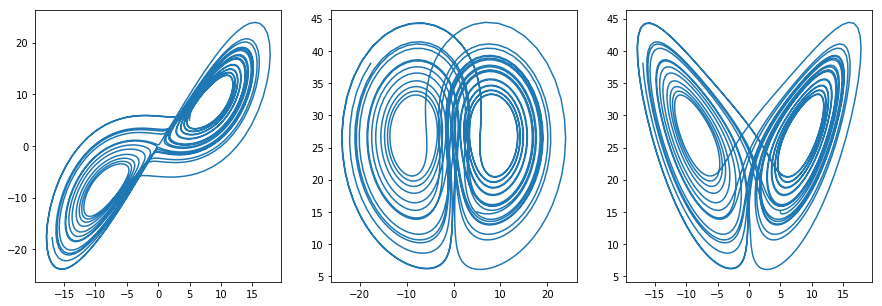

In [13]:
# generate lorenz data

import numpy as np
from scipy import integrate
from scipy.linalg import svd
import matplotlib.pyplot as plt
import pylab

add_noise=False

dimensions = 3
polyOrder = 2

def lorenz_ode(X, t, params):
    
    s,r,b = params
    x,y,z = X

    return [s*(y-x), x*(r-z)-y, x*y-b*z]

M = 25000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample)

t = np.linspace(0,25,M+1)[:-1]; dt = (t[1]-t[0])*subsample_rate

params = (10,28,8.0/3)
X = integrate.odeint(lorenz_ode, [5,5,15], t, args=(params,), rtol = 1e-12, atol = 1e-12)[subsample, :].T

if add_noise:
  X=X*0.9+X*0.2*np.random.rand(X.shape[0],X.shape[1])
x = X[0,:]; y = X[1,:]; z = X[2,:]
if X.shape[0]<X.shape[1]:
  X=X.T



pylab.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,3,1); plt.plot(x)
plt.subplot(1,3,2); plt.plot(y)
plt.subplot(1,3,3); plt.plot(z)
plt.figure()
plt.subplot(1,3,1); plt.plot(x, y)
plt.subplot(1,3,2); plt.plot(y, z)
plt.subplot(1,3,3); plt.plot(x, z)

In [14]:
# prepare data
!wget https://raw.githubusercontent.com/max-hoffman/dimspan-py/master/dimspan/sindy/poolData.py
from poolData import poolData

def normalize(theta):
  dimensions=theta.shape[1]
  norms = np.zeros(dimensions)
  normalizedData = np.copy(theta)

  for dim in range(dimensions):
    newNorm = np.linalg.norm(theta[:,dim], ord=2) # / len(inputData)
    normalizedData[:, dim] = normalizedData[:, dim] / newNorm
    norms[dim] = newNorm
  return normalizedData,norms



theta = poolData(X,dimensions,polyOrder,False)
theta,dim_norms = normalize(theta)
#X=np.multiply(X,1/dim_norms)

--2019-08-13 14:58:47--  https://raw.githubusercontent.com/max-hoffman/dimspan-py/master/dimspan/sindy/poolData.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2657 (2.6K) [text/plain]
Saving to: ‘poolData.py’

poolData.py         100%[===================>]   2.59K  --.-KB/s    in 0s      

2019-08-13 14:58:47 (52.4 MB/s) - ‘poolData.py’ saved [2657/2657]



In [0]:
# estimate derivatives

def fourthOrderDerivative(inputData, dt, dimensions):
  if inputData.shape[0]<inputData.shape[1]:
    inputData=inputData.T
  numDer = np.zeros((inputData.shape[0], dimensions))

  for c in range(dimensions):
    for r in range(numDer.shape[0]):
      if r < 2 or r >= numDer.shape[0] - 2:
        continue

      currentAppx = (1 / (12 * dt)) * (-inputData[r+2][c] + 8*inputData[r+1][c] - 8*inputData[r-1][c] + inputData[r-2][c])
      numDer[r, c] = currentAppx

  return numDer[2:len(numDer)-2, :]


dX = fourthOrderDerivative(X, dt, dimensions)
if theta.shape[0]>dX.shape[0]:
  theta=theta[2:X.shape[0]-2, :]
  X=X[2:X.shape[0]-2, :]

In [16]:
# pick thresholds and iterate

# project one onto the other
Xi, _, _, _ = np.linalg.lstsq(theta, dX)
#thresh=(8/4)*dim_norms[1]*np.ones((dimensions,1))
if add_noise:
  thresh=1135*np.ones((dimensions,1))
else:
  thresh=2*np.ones((dimensions,1))
  
print(thresh)
def estimate_Xi(Xi,theta,dX,dimensions,thresh):
  in_steady_state=False
  while not in_steady_state:
    oldXi=Xi.copy()
    Xi=np.zeros(oldXi.shape)
    threshold_met=True
    for dim in range(dimensions):
      bigIdx = abs(oldXi[:, dim]) > thresh[dim]
      tempXi, _, _, _ = np.linalg.lstsq(theta[:, bigIdx],dX[:, dim])
      Xi[bigIdx,dim]=tempXi
      threshold_met = threshold_met and not(any(abs(Xi[bigIdx,dim])<=thresh[dim]))
    in_steady_state=np.array_equal(Xi,oldXi) and threshold_met
  return Xi

Xi2=estimate_Xi(Xi,theta,dX,dimensions,thresh)

print(np.multiply(Xi2.T,1/dim_norms).T)
#print(Xi2)

[[2.]
 [2.]
 [2.]]
[[ 0.          0.          0.        ]
 [-9.99987216 27.99780692  0.        ]
 [ 9.99987083 -0.99950468  0.        ]
 [ 0.          0.         -2.6666032 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99997612]
 [ 0.         -0.99994208  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


This next example is for partial differential equations. It is taken from a github where in 2016 the researchers extended the SINDy methodology.

https://colab.research.google.com/github/snagcliffs/PDE-FIND/blob/master/Examples/Burgers.ipynb

# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.


# NOTE: unfortunately they used python 2.7 so you have to change the runtime

In [1]:
!git clone https://github.com/snagcliffs/PDE-FIND

Cloning into 'PDE-FIND'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 94 (delta 0), reused 1 (delta 0), pack-reused 91
Unpacking objects: 100% (94/94), done.


In [2]:
cd ./PDE-FIND

/content/PDE-FIND


PDEs
!clone https://github.com/snagcliffs/PDE-FIND


https://colab.research.google.com/github/snagcliffs/PDE-FIND/blob/master/Examples/ReactionDiffusion.ipynb

In [0]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio
import itertools
import matplotlib.pyplot as plt

In [0]:
data = sio.loadmat('./Datasets/burgers.mat')
u = np.real(data['usol'])
x = np.real(data['x'][0])
t = np.real(data['t'][:,0])
dt = t[1]-t[0]
dx = x[2]-x[1]

Text(0.5,0,'t')

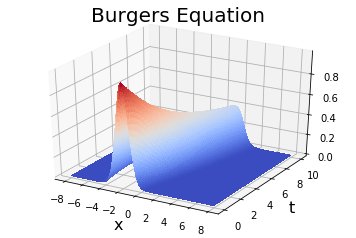

In [5]:
X, T = np.meshgrid(x, t)
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap="coolwarm",
    linewidth=0, antialiased=False)
ax.set_title('Burgers Equation', fontsize = 20)
ax.set_xlabel('x', fontsize = 16)
ax.set_ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,1)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

PDE_FIND.py:437: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
PDE_FIND.py:583: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
PDE_FIND.py:609: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicit

PDE derived using STRidge
u_t = (-1.000987 +0.000000i)uu_{x}
    + (0.100220 +0.000000i)u_{xx}
   


In [8]:
err = abs(np.array([(1 -  1.000987)*100, (.1 - 0.100220)*100/0.1]))
print "Error using PDE-FIND to identify Burger's equation:\n"
print "Mean parameter error:", np.mean(err), '%'
print "Standard deviation of parameter error:", np.std(err), '%'

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.15935000000000255 %
Standard deviation of parameter error: 0.06064999999999543 %


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [0]:
np.random.seed(0)
un = u + 0.01*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

In [0]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)

In [11]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.009655 +0.000000i)uu_{x}
    + (0.102966 +0.000000i)u_{xx}
   


In [12]:
err = abs(np.array([(1 -  1.009655)*100, (.1 - 0.102966)*100/0.1]))
print "Error using PDE-FIND to identify Burger's equation with added noise:\n"
print "Mean parameter error:", np.mean(err), '%'
print "Standard deviation of parameter error:", np.std(err), '%'

Error using PDE-FIND to identify Burger's equation with added noise:

Mean parameter error: 1.9657499999999966 %
Standard deviation of parameter error: 1.0002499999999996 %
